In [57]:
import pandas as pd
import numpy as np
import arcpy
import os
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import pydotplus
from IPython.display import Image
from matplotlib.ticker import FuncFormatter
%matplotlib inline

PATH = 'C:\\Users\\Charles\\Documents\\ArcGIS\\SF_election_2016'

In [51]:
source_files = [x for x in os.listdir(PATH + '\\derived_data') if x.endswith('.txt') and x != 'SF_2010_pop_block.txt']
exclude = [
    '110 - U.S. Representative, District 12.txt',
    '115 - U.S. Representative, District 13.txt',
    '120 - U.S. Representative, District 14.txt',
    '140 - Board of Supervisors, District 1.txt',
    '145 - Board of Supervisors, District 3.txt',
    '155 - Board of Supervisors, District 7.txt',
    '160 - Board of Supervisors, District 9.txt',
    '165 - Board of Supervisors, District 11.txt',
    '185 - BART Director, District 7.txt',
    '190 - BART Director, District 9.txt',
]
join_df = None
for f in source_files[:-1]:
    if f in exclude:
        continue
    df = pd.read_csv(PATH + '\\derived_data\\' + f)
    agg_dict = {x: 'sum' for x in df.columns[7:]}
    agg_dict['ballots_cast'] = 'sum'
    df = df.rename(columns={'precinct_id': 'precinctid'})
    df = df.groupby('precinctid').agg(agg_dict).reset_index()
    df = df.drop(['under_vote', 'over_vote'], axis='columns')
    df[[x for x in df.columns if x not in ('precinctid', 'ballots_cast')]] = df[[x for x in df.columns if x not in ('precinctid', 'ballots_cast')]].div(df['ballots_cast'], axis=0)
    df = df.rename(columns={x: x + '_' + ''.join([y for y in f[6:-4].lower().replace(' ', '_') if y.isalnum() or y == '_']) for x in df.columns[1:]})
    if join_df is None:
        join_df = df
    else:
        join_df = join_df.merge(df, how='left', left_on='precinctid', right_on='precinctid', suffixes=['_main', '_' + f[6:-4].lower().replace(' ', '_')])

In [52]:
feature_df = join_df.drop('precinctid', axis='columns').copy()

# Clean the feature data
feature_df = feature_df.drop([x for x in feature_df.columns if 'us_representative' in x or 'state_assembly' in x], axis='columns')
feature_df = feature_df[~pd.isnull(feature_df['yes_local_measure_u'])]
feature_df = feature_df[~pd.isnull(feature_df['dean_preston_board_of_supervisors_district_5'])]
classes = (feature_df['dean_preston_board_of_supervisors_district_5'] > feature_df['london_breed_board_of_supervisors_district_5']).astype(int)
# We'll also calculate percent dean here for when we use a regresion tree later on
endogenous = feature_df['dean_preston_board_of_supervisors_district_5'] / (feature_df['dean_preston_board_of_supervisors_district_5']+feature_df['london_breed_board_of_supervisors_district_5']) 
feature_df = feature_df.drop(['dean_preston_board_of_supervisors_district_5', 'london_breed_board_of_supervisors_district_5'], axis='columns')

## Classification Tree

In [53]:
classifier = DecisionTreeClassifier(class_weight='balanced')
classifier.fit(feature_df.values, classes)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

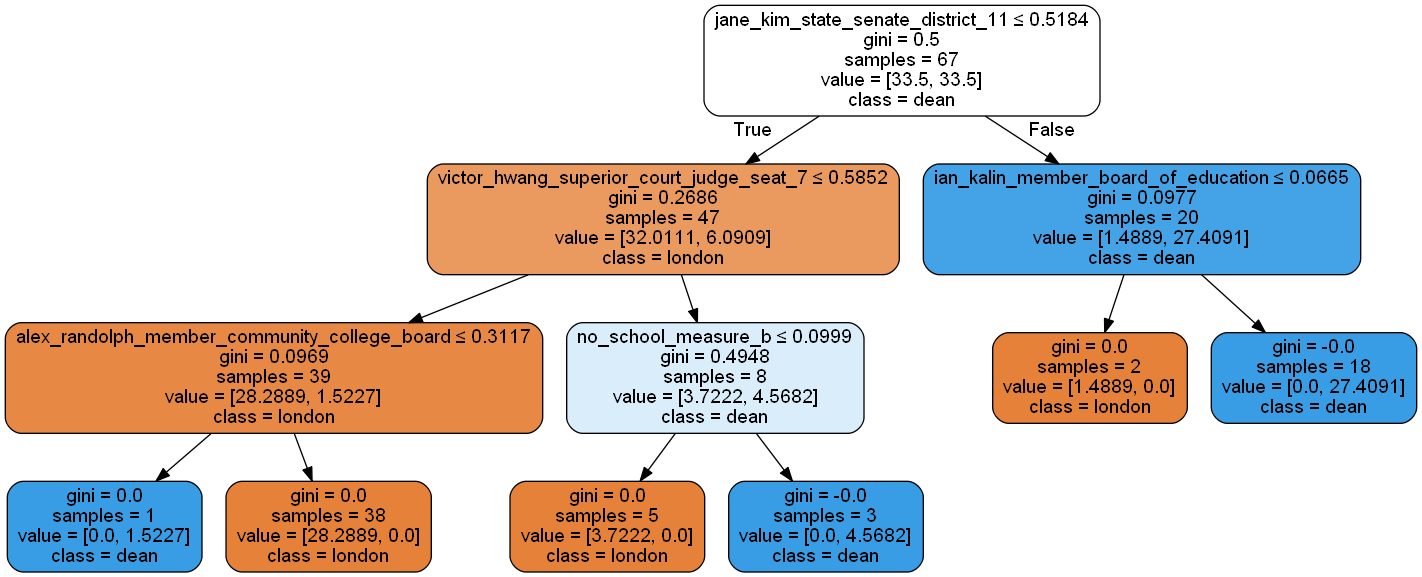

In [54]:
dot_data = tree.export_graphviz(classifier, out_file=None,
                                feature_names=feature_df.columns,
                                class_names=['london', 'dean'],
                                filled=True, rounded=True,
                                special_characters=True,
                                proportion=False
                               )  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

#### Notes
Jane being the primary split is unsurprising - the other splits make less sense. The Ian Kalin and School Measure B splits, in particular, are pretty definitely overfitted, given how low their split values are, and given how few samples fall into each of their smaller leaves. The Victor Hwang split seems plausible, both quantitatively and based on local politics, but the Alex Randolph split only has one sample in the dean leaf, so that's pointless. We could try this again with a higher minimum number of samples per leaf, but this doesn't tell us much anyway; a 51% dean precicnt and a 49% dean precinct being classified diffently is probably arbitrary and artificial to begin with. A regression tree should work better here, so we'll now try that.

## Regression Tree

In [65]:
regressor = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5
)
regressor.fit(feature_df.values, endogenous)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=10,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

#### Notes
These choices are largely arbitrary; they are to make the tree readable/useful, and prevent overfitting by forcing leafs to have at least 5 precincts.

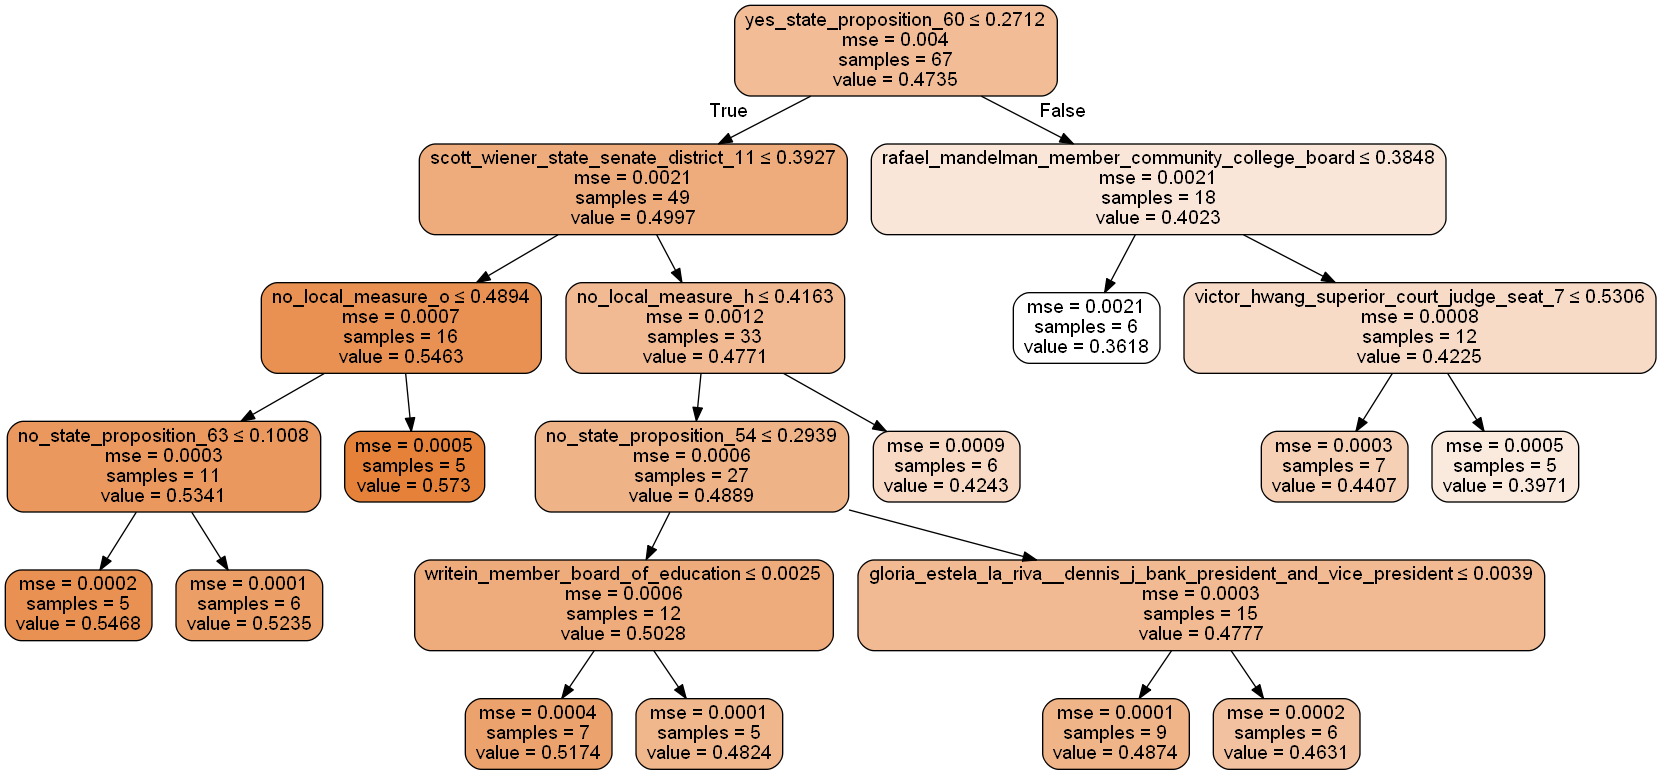

In [66]:
dot_data = tree.export_graphviz(regressor, out_file=None,
                                feature_names=feature_df.columns,
                                class_names=['london', 'dean'],
                                filled=True, rounded=True,
                                special_characters=True,
                                proportion=False
                               )  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

#### Notes
As a first pass, this looks better; it, at least conceptually/poitically, mostly makes sense. State prop 60 (mandatory condom use in porn) is an incredibly weird choice to be the most defining aspect of voters' supervisor preference, but we saw in the linear regression as well that it had the highest r^2 of any ballot measure and a steep slope, so this is consistent with that.

As next steps:
  - First and foremost should probably be to remove pointless features; I don't actually believe that voting for the PSL presidential line at a rate greater or less than .3% is a meaningful predictor of how a precinct would vote for supervisor..
  - Actually do a train/test/CV trial with this to see if it's a good predictor